# HW3-B. Defining an Encoder-Decoder model (solution)

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

While usually not advised, you might want to run the code for this homework using CPU only. It remains possible, however, to use GPU, but we would advise against it, until we have been able to clarify the reason for bugs (most likely some CUDA reason).

In [2]:
# Use GPU if available, else use CPU
device = torch.device('cpu')
print(device)

cpu


## 0. Dataset and Dataloaders from earlier

We start by loading our dataset from the Excel file, and reuse our Dataset and Dataloader objects from HW3-A.

In [3]:
# Load dataset from file
excel_file_path = 'dataset.xlsx'
times, values = load_dataset(excel_file_path)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, times, values, n_inputs, n_outputs):
        self.times = times
        self.values = values
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.define_samples()

    def define_samples(self):
        self.inputs = []
        self.outputs = []
        self.mid = []
        # Define all inputs
        for i in range(len(times) - self.n_inputs - self.n_outputs + 1):
            # Last input not included (only 19 values)
            next_input = self.values[i:(i + self.n_inputs - 1)]
            next_output = self.values[(i + self.n_inputs):(i + self.n_inputs + self.n_outputs)]
            # Mid is the turning point, i.e. the value of the 20-th sample in the series of inputs
            # It will not be read by the encoder and will serve as the first input to the decoder
            next_mid = [self.values[i + self.n_inputs - 1]]
            self.inputs.append(next_input)
            self.outputs.append(next_output)
            self.mid.append(next_mid)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Select samples corresponding to the different inputs
        # and outputs we have created with the define_samples() function,
        # and convert them to PyTorch tensors
        x = torch.tensor(self.inputs[idx], dtype = torch.float32)
        y = torch.tensor(self.outputs[idx], dtype = torch.float32)
        m = torch.tensor(self.mid[idx], dtype = torch.float32)
        return x, y, m

In [5]:
# Create our PyTorch Dataset object from the class above
n_inputs = 20
n_outputs = 5
pt_dataset = CustomDataset(times, values, n_inputs, n_outputs)

In [6]:
# Create DataLoader object
batch_size = 256
pt_dataloader = DataLoader(pt_dataset, batch_size = batch_size, shuffle = True)

## 1. Step 1: Designing an Encoder model

We propose to approach this task, by using and Encoder-Decoder model of some sort. Both the Encoder and Decoder parts of the model will consist of a simple LSTM.

**Question 6:** What is a Seq2Seq model, and how does it relate to Encoder-Decoder models?

<div class="alert alert-block alert-info">
<b>Answer Q6: The core idea of a Seq2Seq model is to map a sequence of inputs (words, characters, etc.) to a sequence of outputs, which can be of different lengths. Seq2Seq models are closely related to, and typically implemented using, Encoder-Decoder architectures, which breaks down the Seq2Seq model in two smaller models, an Encoder and a Decoder, through which data will flow sequentially. </b> 
</div>

We want to implement the LSTM architecture drawn below. It objective is to receives entires $ x(t), x(t+1), ..., x(t+18) $, 19 input points, and learn the dynamics of the data, in the hopes that we will later be able to use this information for future predictions.

<img title="Our Encoder Architecture" alt="Our Encoder Architecture" src="./images/20240318_183921.jpg">

Given the LSTM Architecture above, answer the questions below.

**Question 7:** This encoder seems to receive all inputs present in the first tensor coming from the Dataloader object, which includes n_inputs - 1 elements (here 20-1 = 19 inputs). This LSTM could then produce 19 outputs, but for some reason, they are not shown on this image. What is the reason for this omission? Why is our diagram suggesting that the final memory vector is the only important information that will come out of this encoder model?

<div class="alert alert-block alert-info">
<b>Answer Q7: We do not care about the 19 outputs produced by this LSTM, its only purpose is to read the data and incorporate information about the data dynamics. This information will progressively be incorporated in the memory vector, and its final value will hopefully contains all the information we need to know about the sequential input, to make accurate predictions later on. </b> 
</div>

We want our Encoder model to be represented by the EncoderRNN object, whose class prototype is shown below.

**Question 8:** There are a few Nones to be replaced in the code below. Please show your code in your report after you have figured out the correct EncoderRNN class.

<div class="alert alert-block alert-info">
<b>Answer Q8: A possible implementation is shown below. </b> 
</div>

<div class="alert alert-block alert-info">
<b> Note: Some students have also reported other possible implementations, which seemed more stable on old PyTorch versions and MacOS architectures. Keep in mind that they were not necessarily the expected design for this task, and it might not be able to use the pre-trained weights we were providing or interface nicely with the DecoderRNN suggested design, but as long as it works, we are willing to accept it. </b> 
</div> 

<div class="alert alert-block alert-info">
<b> Important note: We need to be careful about the shape of the inputs tensor. The tensors produced do not match the expected shape we want for the LSTM layer, which should be (batch_size, n_inputs, H_in = 1). Refer to the documentation here, for details: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html</b> 
</div> 

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(1, hidden_size, batch_first = True)

    def forward(self, inputs):
        output, hidden = self.lstm(inputs.unsqueeze(-1))
        # Return the final hidden state to be used by the decoder
        return hidden

In [8]:
# Defining our EncoderRNN model
hidden_size = 25
encoder_model = EncoderRNN(n_inputs, hidden_size).to(device)
print(encoder_model)

EncoderRNN(
  (lstm): LSTM(1, 25, batch_first=True)
)


**Question 9:** Consider the cell below. What is contained in *vec1\[0\]* and *vec2\[0\]*?

<div class="alert alert-block alert-info">
<b>Answer Q9: The values shown are the final values of the memory vectors produced by the LSTM (i.e. the vectors h and c, discussed in class). </b> 
</div>

In [9]:
# Testing our EncoderRNN model
inputs, _, _ = next(iter(pt_dataloader))
inputs_reworked = inputs[0, :].reshape(1, 19)
encoder_out = encoder_model(inputs_reworked.to(device))
vec1, vec2 = encoder_out
print(vec1[0])
print(vec2[0])

tensor([[ 8.9897e-04,  1.0540e-01,  4.4527e-06, -7.5011e-01,  5.2134e-05,
         -9.9691e-01,  1.4404e-06,  1.7983e-03,  1.9923e-12, -7.6298e-01,
         -8.9474e-01,  1.7904e-09,  1.0000e+00, -1.0000e+00,  1.4825e-07,
          4.8693e-01, -5.3135e-01, -1.6709e-03,  2.8252e-07,  1.0133e-05,
          9.9695e-01,  1.4412e-04,  2.3275e-01,  6.3486e-06,  2.2393e-08]],
       grad_fn=<SelectBackward0>)
tensor([[ 9.9402e-01,  1.0580e-01,  4.4528e-06, -9.7322e-01,  5.2137e-05,
         -1.8999e+01,  1.4404e-06,  2.6546e-03,  6.2677e-06, -1.0034e+00,
         -1.4454e+00,  2.9541e-03,  1.8290e+01, -1.7602e+01,  1.5021e-07,
          1.8991e+01, -1.1382e+00, -1.0036e+00,  9.9997e-01,  1.0976e+01,
          3.2421e+00,  9.3686e-01,  1.2041e+00,  6.3494e-06,  5.8513e-04]],
       grad_fn=<SelectBackward0>)


## 2. Step 2: Designing a Decoder model

Our next step is to produce a decoder model. It will receive a certain memory vector as its memory starting point. It will also receive five inputs denoted *val1*, *val2*, *val3*, *val4*, and *val5*. It will then attempt to produce five outputs denoted *y1*, *y2*, *y3*, *y4*, and *y5*.

Consider the architecture drawn below and answer the following questions.

As you can see, it will receive certain input values *valk* and will attempt to predict a value *yk*, with k in $ \{1, 2, 3, 4, 5\} $.

<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/20240318_184112.jpg">

**Question 10:** Assuming that the encoder has seen the inputs $ x(t), x(t+1), ... x(t+18) $, what should we use as a memory vector to play the role of the memory starting point for the decoder?

<div class="alert alert-block alert-info">
<b>Answer Q10: We should use the final memory vector that has been produced by the encoder. </b> 
</div>

**Question 11:** We will use a Decoder that is NOT auto-regressive. What does that mean for the input and output values of our Decoder LSTM-based model?

<div class="alert alert-block alert-info">
<b>Answer Q11: It simply means that the predicted outputs of a given LSTM will not be reused as inputs for the next LSTM cell. Instead, we will use as inputs for these LSTM, values that are coming from the dataset. </b> 
</div>

**Question 12:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+18) $, which values should we use in place fo *val1*, *val2*, *val3*, *val4*, *val5*? Remember Q11, we are not planning to use an auto-regressive decoder here. Could you then explain why we only used 19 values as inputs in the encoder part then?

<div class="alert alert-block alert-info">
<b>Answer Q12: We should use the single value in the mid tensor as val1, it consists of $ x(t+19) $, the twentieth value in inputs. After that, we will simply use the first four values in the output tensor as val2, val3, val4, and val5. These correspond to $ x(t+20), x(t+21), x(t+22) $, and $ x(t+23) $. The reason why we do not use all inputs, but only 19 of them has to do with the fact that we do not want the value $ x(t+19) $ to be used as input in two different LSTMs (final pass of the encoder and first pass of the decoder). This could be seen as an unnecessary repetition. </b>
</div>

**Question 13:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+18) $, which values should we use in place fo *val1*, *val2*, *val3*, *val4*, *val5*? Remember Q11, we are not planning to use an auto-regressive decoder here.

<div class="alert alert-block alert-info">
<b>Answer Q13: We should use the single value in the mid tensor as val1. After that, we will simply use the first four values in the output tensor as val2, val3, val4, and val5. The five valk values will then be replaced by the ground truth values of $ x(t+19), x(t+20), ... x(t+23) $. </b>
</div>

**Question 14:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+18) $, what are the target values should we are trying to match with our predictions in place fo *y1*, *y2*, *y3*, *y4*, *y5*?

<div class="alert alert-block alert-info">
<b>Answer Q14: We are trying to match the ground truth values of the ouputs tensor $ x(t+20), x(t+21), ... x(t+24) $. </b>
</div>

**Question 15:** Having figured out the questions in Q10-14, can you figure what to use in place of the Nones in the code for the DecoderRNN below? Show your final code in your report.

<div class="alert alert-block alert-info">
<b>Answer Q15: A possible solution is shown below. </b>
</div>

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(1, self.hidden_size, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, outputs, mid, encoder_hidden_states):
        hidden_states = encoder_hidden_states
        final_pred = torch.zeros(outputs.shape)
        val = mid.reshape(mid.shape[0], mid.shape[1], 1)
        for i in range(outputs.shape[1]):
            pred, hidden_states = self.lstm(val, hidden_states)
            pred = self.linear(pred)
            final_pred[:, i] = pred.squeeze()
            val = outputs[:, i].reshape(outputs.shape[0], 1, 1)
        return final_pred

<div class="alert alert-block alert-info">
<b> Note: Some students have also reported other possible implementations, which seemed more stable on old PyTorch versions and MacOS architectures. We show some of them below. Keep in mind that they were not necessarily the expected design for this task, and it might not be able to use the pre-trained weights we were providing, but as long as it works, we are willing to accept it. We will adjust our grading accordingly, as long as you managed to produce a Seq2Seq model that trains in the end. </b> 
</div> 

In [11]:
# Defining our DecoderRNN model
decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = n_outputs)
print(decoder_model)

DecoderRNN(
  (lstm): LSTM(1, 25, batch_first=True)
  (linear): Linear(in_features=25, out_features=1, bias=True)
)


**Question 16:** Consider the cell below. What should the final size of the *decoder_out* tensor be?

<div class="alert alert-block alert-info">
<b>Answer Q16: It should be 256 (batch size) by 5 (number of outputs). </b>
</div>

In [12]:
# Testing our DecoderRNN model
inputs, outputs, mid = next(iter(pt_dataloader))
encoder_out = encoder_model(inputs.to(device))
decoder_out = decoder_model(outputs.to(device), mid.to(device), encoder_out)
print(decoder_out.shape)

torch.Size([256, 5])


## Step 3: Assembling everything into a Seq2Seq model.

Our final objective is to assemble both our encoder model and decoder model into a Seq2Seq model, following the architecture drawn below.

<img title="Our Seq2Seq Architecture" alt="Our Seq2Seq Architecture" src="./images/20240318_184350.jpg">

**Question 17:** Why have we prefered to use a Decoder-Encoder architecture, instead of a single LSTM that would receive 24 inputs, produce 24 outputs, and would only compare the final 5 predicted values to the ground truth in our dataset?

<div class="alert alert-block alert-info">
<b>Answer Q17: Typically, we prefer to split the two tasks at hand here. The first task is to read input data and develop an understanding about the dynamics of the data. The second task requires to use that knowledge to predict the next five values of the stock market. Following observations we have made in W6, we have decided to decorrelate both tasks, using two distinct models to do so, respectively an Encoder and a Decoder. </b>
</div>

**Question 18:** Having figured out the models in EncoderRNN and DecoderRNN, can you now figure out the missing code in the cell below? Show it in your report.

<div class="alert alert-block alert-info">
<b>Answer Q18: A possible solution is shown below. </b>
</div>

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_model = EncoderRNN(self.input_size, self.hidden_size)
        self.decoder_model = DecoderRNN(self.hidden_size, self.output_size)

    def forward(self, inputs, outputs, mid):
        encoder_hidden_states = self.encoder_model(inputs)
        pred_final = self.decoder_model(outputs, mid, encoder_hidden_states)
        return pred_final

In [14]:
# Defining our Seq2Seq model
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs)
print(seq2seq_model)

Seq2Seq(
  (encoder_model): EncoderRNN(
    (lstm): LSTM(1, 25, batch_first=True)
  )
  (decoder_model): DecoderRNN(
    (lstm): LSTM(1, 25, batch_first=True)
    (linear): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [15]:
# Testing our Seq2Seq model
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs)
inputs, outputs, mid = next(iter(pt_dataloader))
print(inputs.shape, outputs.shape, mid.shape)
seq2seq_out = seq2seq_model(inputs, outputs, mid)
print(seq2seq_out.shape)

torch.Size([256, 19]) torch.Size([256, 5]) torch.Size([256, 1])
torch.Size([256, 5])


## Step 4: Finally, training and evaluating our Seq2Seq model

**Question 19:** Given your understanding of the task, which (very simple) loss function should we use in our trainer function? Show your updated code in your report.

<div class="alert alert-block alert-info">
<b>Answer Q19: We should simply use MSE! After all, this is a simple regression task... Some students, however, decided to go for other loss functions, for instance MAE, which is also valid for this task, although surprising. Either way, a possible solution is shown below. </b>
</div>

In [16]:
def train(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs, mid in dataloader:
            inputs, outputs, mid = inputs.to(device), outputs.to(device), mid.to(device)
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs, mid)
            # Calculate loss
            loss = criterion(pred.to(device), outputs.to(device))
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()          
        
        # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss/len(dataloader)}')

Having figure out the correct models and trainer function, you may not use the celml below. It will train the model from scratch, on 50 iterations and will show you the amount of time take to train this model. This is just information to let you know how long the full training loop (in the next cell), might take on your machine!

In [17]:
# Training the model
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 256, learning_rate = 1e-3)

Epoch 1/256, Avg Loss: 1923.0369720458984
Epoch 26/256, Avg Loss: 1096.0527458190918
Epoch 51/256, Avg Loss: 723.4822425842285
Epoch 76/256, Avg Loss: 484.3912239074707
Epoch 101/256, Avg Loss: 323.4655704498291
Epoch 126/256, Avg Loss: 212.2841625213623
Epoch 151/256, Avg Loss: 137.20113515853882
Epoch 176/256, Avg Loss: 89.26825666427612
Epoch 201/256, Avg Loss: 58.122708797454834
Epoch 226/256, Avg Loss: 37.42888784408569
Epoch 251/256, Avg Loss: 23.633161902427673
53.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
# This was used to save a starting point for the next cell, do not run.
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_start.pth')

**Question 20:** It seems the loss values we are seeing when using the model with randomly initialized parameters is very high. While it seems to decrease, it seems lots of iterations will be needed. The next cell suggests to run the training loop, but initialize the weights of the model using values in the *seq2seq_model_start.pth* file, presumably coming from another roughly similar model, trained on a different but similar task. This is done in an attempt to help the model train better and faster. Under which name is this concept known in Deep Learning?

<div class="alert alert-block alert-info">
<b>Answer Q20: Transfer learning. </b>
</div>

<div class="alert alert-block alert-info">
<b>Note: The next cell will take a (somewhat) long time to run. On my machine CPU, it takes ~4minutes. You can simply guess how long it will take to run on your machine, by using the execution time of the previous cell (using 50 iterations) and multiplying that by 20. As mentioned at the beginning of this Notebook, we have observed issues in running the code, on some CUDA machines. It is unclear at the moment, so try GPU computing at your own risk... </b>
</div>

In [19]:
# Training the model
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
# Start from given parameters to make training easier
seq2seq_model.load_state_dict(torch.load('seq2seq_model_start.pth'))
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

Epoch 1/1051, Avg Loss: 20.74195122718811
Epoch 26/1051, Avg Loss: 3.3959648311138153
Epoch 51/1051, Avg Loss: 0.7091798428446054
Epoch 76/1051, Avg Loss: 0.27647418109700084
Epoch 101/1051, Avg Loss: 0.16681712120771408
Epoch 126/1051, Avg Loss: 0.1173065253533423
Epoch 151/1051, Avg Loss: 0.09515261044725776
Epoch 176/1051, Avg Loss: 0.08528158254921436
Epoch 201/1051, Avg Loss: 0.07845896435901523
Epoch 226/1051, Avg Loss: 0.07502731960266829
Epoch 251/1051, Avg Loss: 0.07480317400768399
Epoch 276/1051, Avg Loss: 0.06817485741339624
Epoch 301/1051, Avg Loss: 0.06583913485519588
Epoch 326/1051, Avg Loss: 0.06834175251424313
Epoch 351/1051, Avg Loss: 0.06482077785767615
Epoch 376/1051, Avg Loss: 0.061870380537584424
Epoch 401/1051, Avg Loss: 0.06198581797070801
Epoch 426/1051, Avg Loss: 0.060463436879217625
Epoch 451/1051, Avg Loss: 0.0641356164123863
Epoch 476/1051, Avg Loss: 0.06391143053770065
Epoch 501/1051, Avg Loss: 0.063647935166955
Epoch 526/1051, Avg Loss: 0.05698854173533618

In [20]:
# Do not uncomment and execute, this was used to prepare the model that you will be using in the final question!
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_end.pth')

**Question 21:** The code below shows the predictions produced by your Seq2Seq model after training and can be used to confirm that you have trained the right model! Show some screenshots in your report, and discuss the final performance you have obtained for your model. For your information, I typically obtain an MSE of ~0.05 after 1000 iterations of training. Additional performance can probably be obtained via hyperparameters tuning (changing the size of memory vector, etc.).

<div class="alert alert-block alert-info">
<b>Answer Q21: Graded to our discretion, based on amount of effort produced by students...! </b>
</div>


In [21]:
# Quick check on our Seq2Seq model
# (Seeding for reproducibility)
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
seed_value = 187
test_model(seq2seq_model, pt_dataloader, seed_value)

Ground truth:  tensor([24.6567, 24.7942, 24.8445, 24.9499, 25.1038])
Prediction:  tensor([24.6929, 24.6387, 24.8158, 24.8631, 24.9835], grad_fn=<SliceBackward0>)
Mean Square Error for Sample:  0.009663835


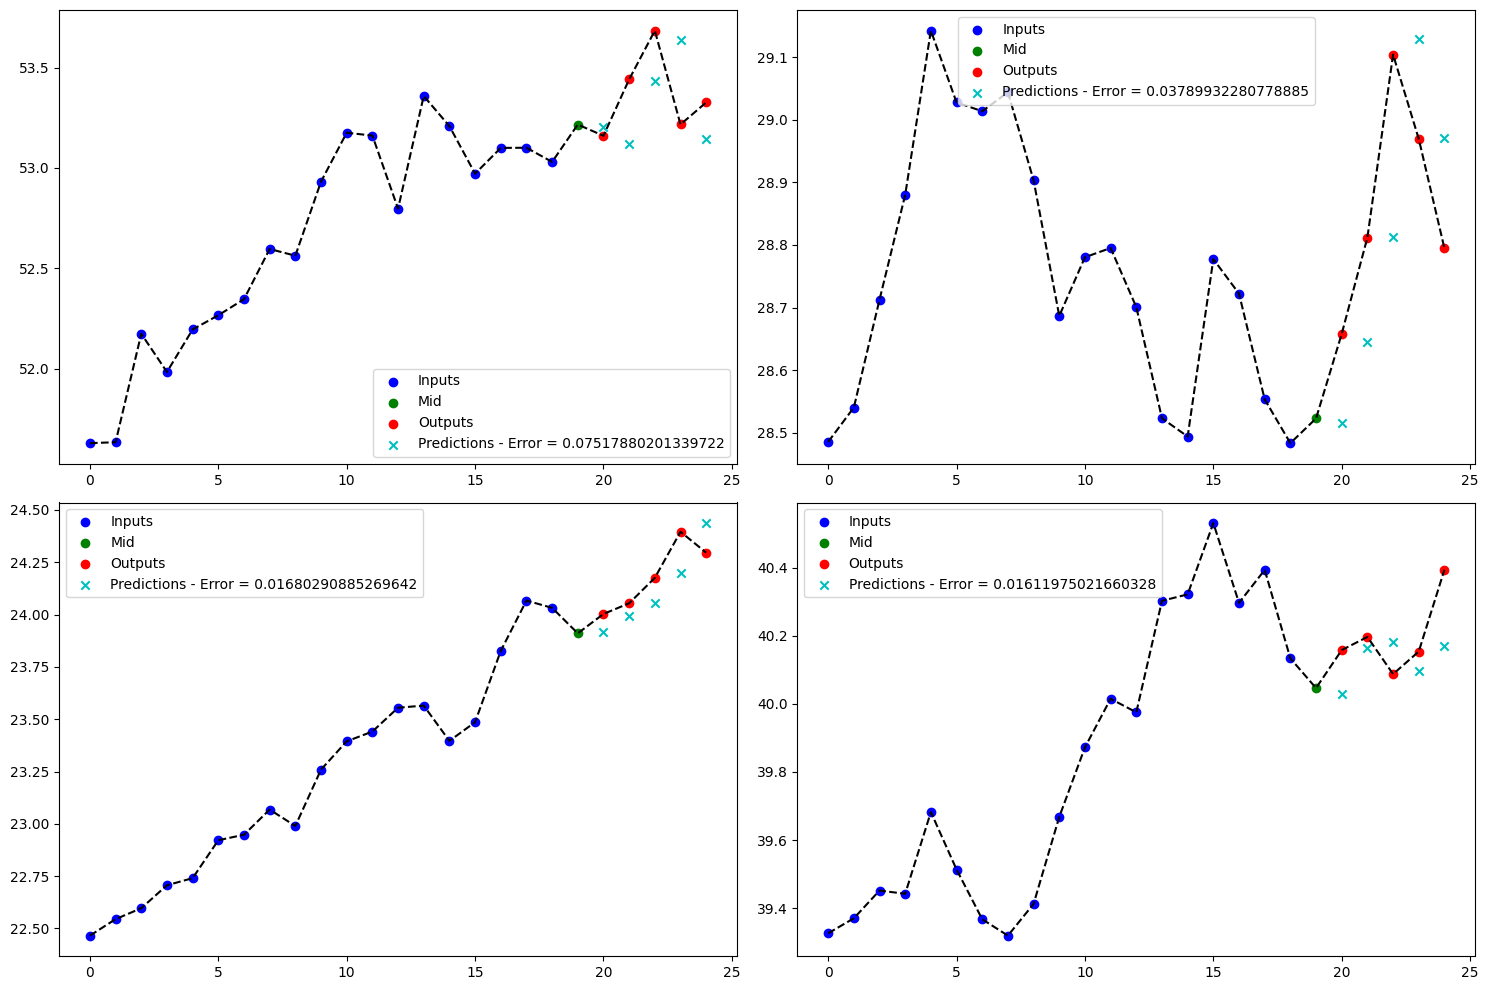

In [22]:
# Reload the model
# (Seeding for reproducibility)
hidden_size = 25
seq2seq_model = Seq2Seq(input_size = n_inputs, \
                        hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

## This concludes HW3.

Do not give up, it is a feasible task! If your model does not work, most likely, you are making a mistake in the Encoder model or - most likely - the Decoder model. Take your time to think about the task at hand and the model we should use for that task.